# Purpose:

2015-03-13 (Friday)

Explore and characterize the results of the learned Beta filter method.

# Contents
[Loading-files](#Loading-files)

[Filtering-Stats](#Filtering-Stats)

[Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs](#Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs)
- [All-contigs](#All-contigs)
- [All-SNP-pair-contigs](#All-SNP-pair-contigs)
- [LD-filtered-SNP-pair-contigs](#LD-filtered-SNP-pair-contigs)

[Compare-with-Tajima's-D-results-from-AndreaG](#Compare-with-Tajima's-D-results-from-AndreaG)
- [Examine-ld_contig_taj_win_filter](#Examine-ld_contig_taj_win_filter)
- [Basic-summary-table-referencing-SNP-pairs](#Basic-summary-table-referencing-SNP-pairs)
- [How-is-q-value-related-to-SNP-pair-distance?](#How-is-q-value-related-to-SNP-pair-distance?)
- [What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50](#What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50)
- [How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin](#How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin)

[Average-LD-per-bin](#Average-LD-per-bin)
- [All-contigs-together](#All-contigs-together)
- [5-random-contigs](#5-random-contigs)
- 

## Imports:

In [66]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm

import munch

import pymc as mc

from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

In [67]:
# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## Save plots?

In [68]:
save_plots = True

## File paths:

In [69]:
# define paths to files

base_out_dir = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld"

fasta_path = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/assemblies/GfusI1/Glossina-fuscipes-IAEA_SCAFFOLDS_GfusI1.fa"
contig_name_length_path = "/home/gus/Dropbox/uganda_data/data_repos/genome_info/assembly_info/contig_name_length.csv"

ld_results_pickle="/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/ld_thresholds/post_MAP_calc.plk"
tajimas_csv = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/Tajima50.csv"

# Record some info about the contigs once and for all

In [70]:
# contig_name_map = GfusI1_0.get_name_map_from_fasta_headers(fasta_path)

In [71]:
# contig_lengths = {}
# contigs = ParseFastA(fasta_path).to_dict()
# for name,seq in contigs.iteritems():
#     contig_lengths[name] = len(seq)

In [72]:
# # record both names and the length

# with open(contig_name_length_path,'w') as out:
#     template = "{kk_name},{scaf_name},{length}\n"
#     out.write(template.format(kk_name="kk_name",scaf_name="scaf_name",length="length"))
    
#     for kk_name, length in contig_lengths.iteritems():
#         out.write(template.format(kk_name=kk_name,
#                                   scaf_name=contig_name_map[kk_name],
#                                   length=length))
    

# Helper functions

In [73]:
def recode_taj_chrom(df):
    recode_func = lambda x: x.split(':')[-1]

    CHROM = df.CHROM.apply(recode_func)
    df.CHROM = CHROM
    
    
def save_figs(base_dir, fname, save_types=('png','pdf','svg'), is_ggplot=False):
    assert (is_ggplot is False) or isinstance(is_ggplot,gp.ggplot)
    
    if not save_plots:
        print "WARNING: 'save_plots' set to False."
    
    path = "{pth}.{{ext}}".format(pth=os.path.join(base_dir,fname))
    
    for t in save_types:
        
        if is_ggplot:
            gp.ggsave(path.format(ext=t),plot=is_ggplot)
        else:
            plt.savefig(path.format(ext=t), bbox_inches='tight')
            print "Saved {0}.".format(path.format(ext=t))


# Loading files

In [74]:
# load our results tables
ld = pd.read_pickle(ld_results_pickle)
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False


In [75]:
contig_info = pd.read_csv(contig_name_length_path)
contig_info.head()

,kk_name,scaf_name,length
0,KK352346.1,Scaffold566,193315
1,KK352610.1,Scaffold839,83110
2,KK352241.1,Scaffold458,243873
3,JFJR01012964.1,JFJR01012964.1,3083
4,KK352052.1,Scaffold268,427914


In [76]:
taj50 = pd.read_csv(tajimas_csv, sep='\t')
taj50.head()

,CHROM,BIN_start,N_SNPs,TajimaD
202,GFvariants_VB2014a_tvcf:KK351785.1,23400,4,2.35852
8242,GFvariants_VB2014a_tvcf:KK351785.1,425400,3,2.31422
66484,GFvariants_VB2014a_tvcf:KK351787.1,68900,2,2.20911
67161,GFvariants_VB2014a_tvcf:KK351787.1,102750,4,2.90971
67278,GFvariants_VB2014a_tvcf:KK351787.1,108600,2,2.08884


In [77]:
recode_taj_chrom(taj50)
taj50.head()

,CHROM,BIN_start,N_SNPs,TajimaD
202,KK351785.1,23400,4,2.35852
8242,KK351785.1,425400,3,2.31422
66484,KK351787.1,68900,2,2.20911
67161,KK351787.1,102750,4,2.90971
67278,KK351787.1,108600,2,2.08884


# Filtering Stats

## SNP-pairs in all bins at BH corrected $p \leq 0.01$

In [78]:
sum(ld.one_minus_cdf_BH <= 0.01)

5284

## SNP-pairs in all bins at BH corrected $p \le 0.05$

In [79]:
sum(ld.one_minus_cdf_BH <= 0.05)

6735

## Lowest $r^2$ retained at  $p \le 0.05$ or $0.01$

In [80]:
q_05 = ld.query("one_minus_cdf_BH <= 0.05")
q_05.R2.min()

0.64724438522499994

In [81]:
q_01 = ld.query("one_minus_cdf_BH <= 0.01")
q_01.R2.min()

0.82251114177599993

## How many SNP-pairs have  $r^2 \ge 0.82$?

In [82]:
sum(ld.R2 >= 0.82)

26495

In [83]:
1-(5284.0/26495)

0.8005661445555765

# Look at many distance_bin areas

In [85]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False


In [104]:
def plot_bin_dists(df, bin_def="distance_bin <= 500"):
    
    g = sns.FacetGrid(data=df.query(bin_def), 
                      col="distance_bin",
                      sharey=False,
                      sharex=False,
                      col_wrap=4,
                     )
    
    
    return g.map(plt.hist, "R2", color="coral");
    

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_0_500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_0_500.svg.


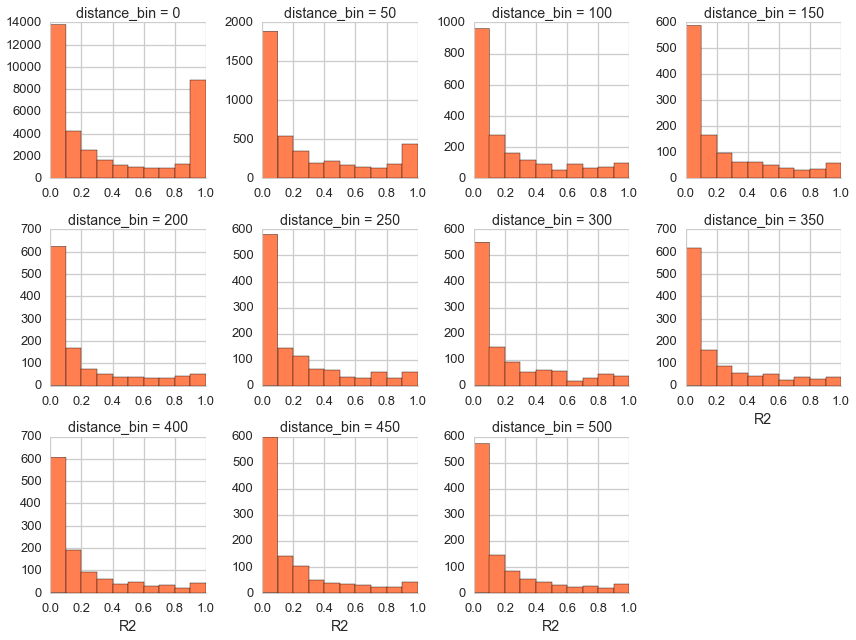

In [105]:
fname = "distance_bins_0_500"

p = plot_bin_dists(ld, bin_def="distance_bin <= 500")
    
p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_7000_7500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_7000_7500.svg.


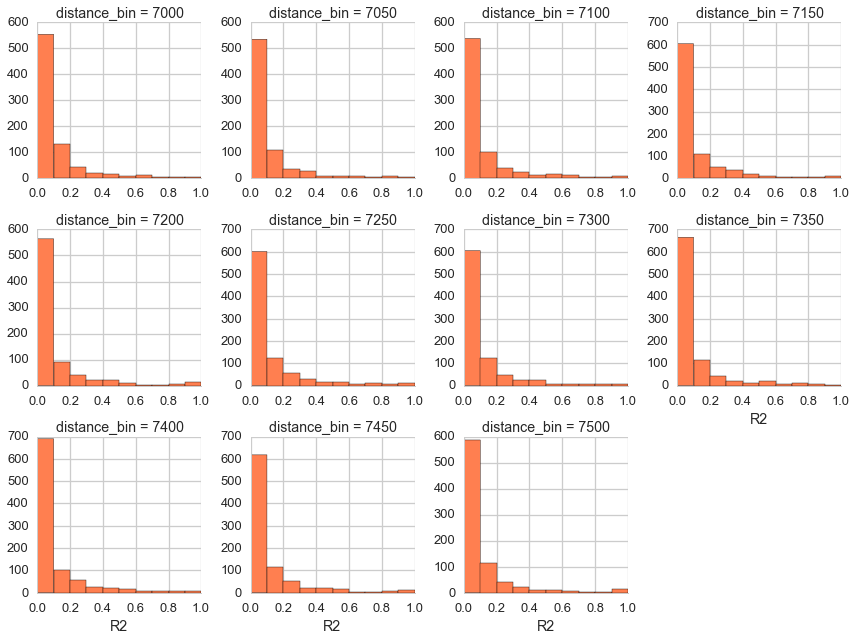

In [108]:
fname = "distance_bins_7000_7500"

p = plot_bin_dists(ld, bin_def="7000 <= distance_bin <= 7500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_15000_15500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_15000_15500.svg.


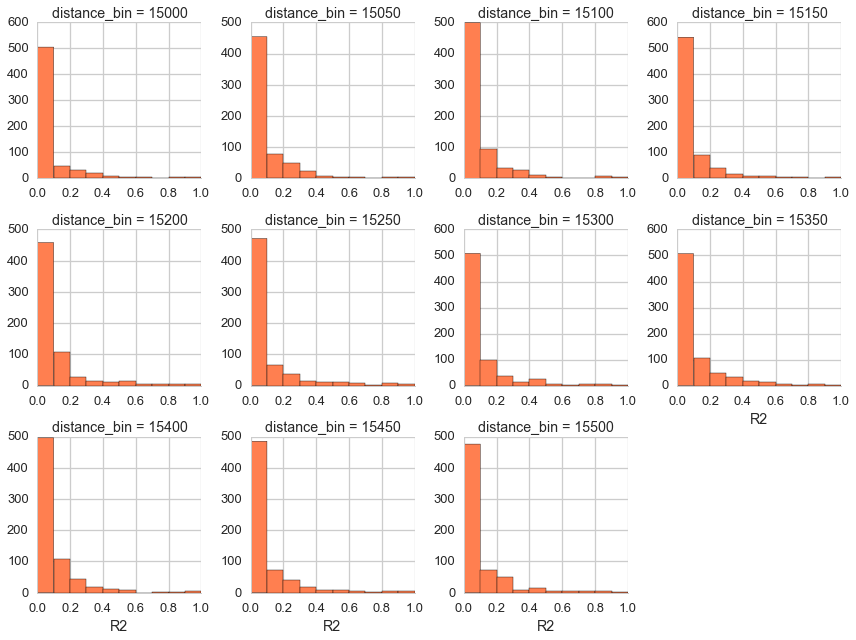

In [109]:
fname = "distance_bins_15000_15500"

p = plot_bin_dists(ld, bin_def="15000 <= distance_bin <= 15500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

ERROR! Session/line number was not unique in database. History logging moved to new session 447
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_30000_30500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_30000_30500.svg.


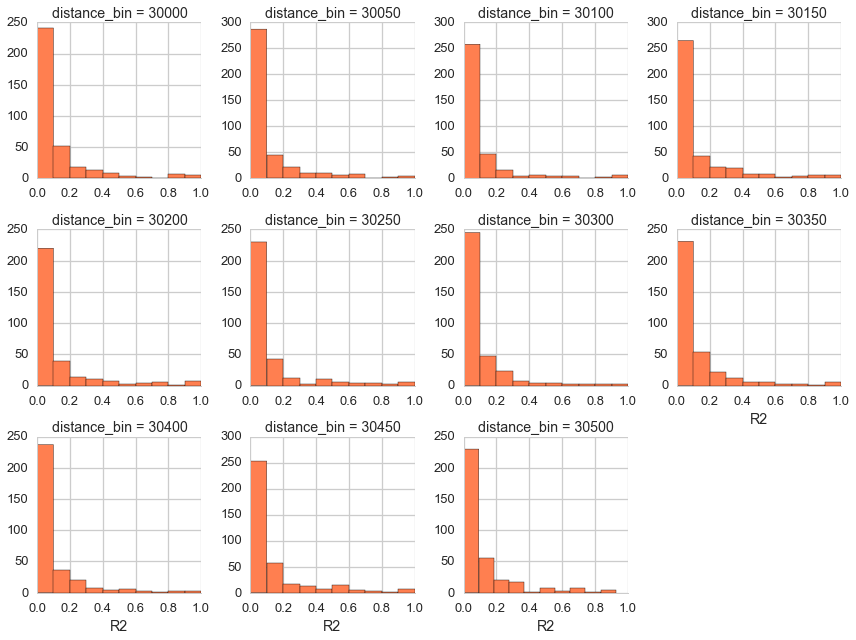

In [112]:
fname = "distance_bins_30000_30500"

p = plot_bin_dists(ld, bin_def="30000 <= distance_bin <= 30500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_50000_50500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_50000_50500.svg.


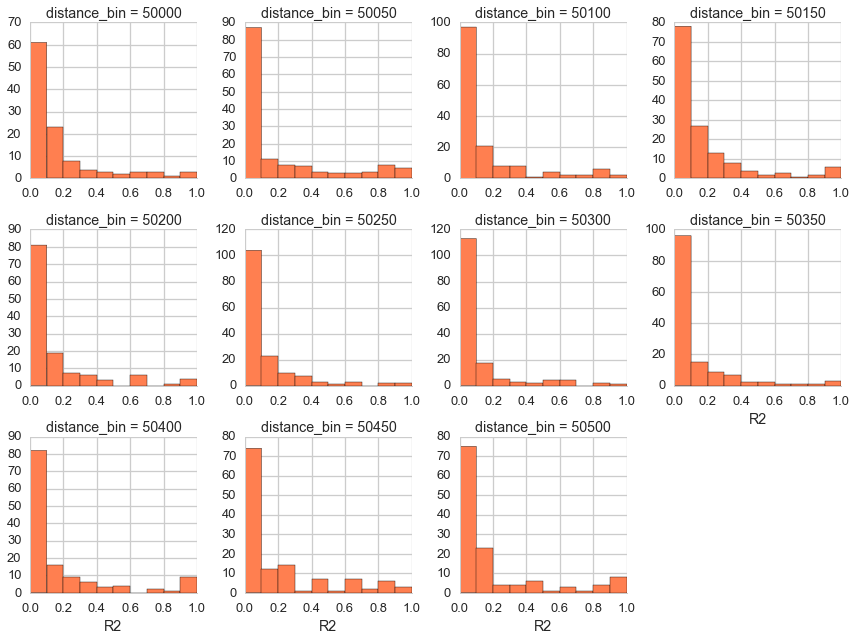

In [113]:
fname = "distance_bins_50000_50500"

p = plot_bin_dists(ld, bin_def="50000 <= distance_bin <= 50500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_70000_70500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_70000_70500.svg.


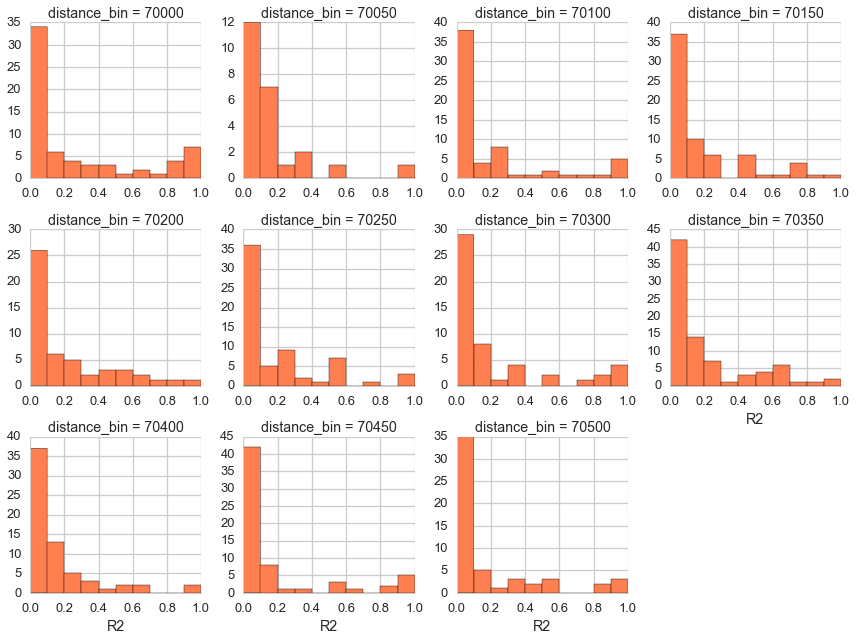

In [115]:
fname = "distance_bins_70000_70500"

p = plot_bin_dists(ld, bin_def="70000 <= distance_bin <= 70500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_100000_100500.png.
Saved /home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/distance_bins_100000_100500.svg.


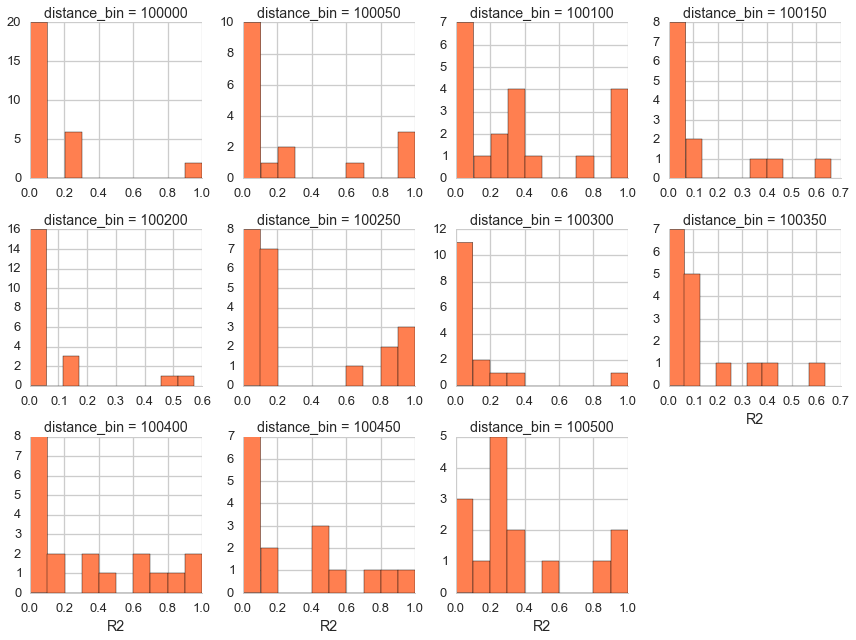

In [116]:
fname = "distance_bins_100000_100500"

p = plot_bin_dists(ld, bin_def="100000 <= distance_bin <= 100500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

## Characterization of contigs with/without regard to selected SNP-pairs

In [ ]:
# join contig length and kk_name contig info to the LD table
ld_contig = pd.merge(left=ld, right=contig_info, how='inner', left_on="CHR_A", right_on="scaf_name")
ld_contig.head()

### All contigs

In [ ]:
fname = "all_contig_len_dist"

sns.distplot(contig_info.length, color="coral", kde=0);
median_contig_len = contig_info.length.median()
mean_contig_len = contig_info.length.mean()
plt.text(median_contig_len,400,"*median length = {}".format(median_contig_len), fontsize=14);
plt.text(mean_contig_len,200,"*mean length = {}".format(mean_contig_len), fontsize=14);
plt.text(mean_contig_len,800,"Number of contigs = {}".format(len(contig_info)), fontsize=14);
plt.title("All contigs");

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','pdf','svg')
         )

### All SNP-pair contigs

In [ ]:
sp_contigs = contig_info[contig_info.scaf_name.isin(ld_contig.scaf_name.unique())]
len(sp_contigs)

In [ ]:
fname = "all_sp_contig_len_dist"

sns.distplot(sp_contigs.length, color="coral", kde=0);
sp_median_contig_len = sp_contigs.length.median()
sp_mean_contig_len = sp_contigs.length.mean()
plt.text(sp_median_contig_len,100,"*median length = {}".format(sp_median_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,50,"*mean length = {}".format(sp_mean_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,200,"Number of contigs = {}".format(len(sp_contigs)), fontsize=14);
plt.title("Contigs with a SNP-pair");

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','pdf','svg')
         )

### LD filtered SNP-pair contigs

In [ ]:
ld_filt_contigs = ld_contig.query("one_minus_cdf_BH <= 0.01")
ld_filt_contigs = contig_info[contig_info.scaf_name.isin(ld_filt_contigs.scaf_name.unique())]
len(ld_filt_contigs)

In [ ]:
fname = "filtered_sp_contig_len_dist"

sns.distplot(ld_filt_contigs.length, color="coral", kde=0);
ld_filt_median_contig_len = ld_filt_contigs.length.median()
ld_filt_mean_contig_len = ld_filt_contigs.length.mean()
plt.text(ld_filt_median_contig_len, 40, "*median length = {}".format(ld_filt_median_contig_len), fontsize=14);
plt.text(ld_filt_mean_contig_len, 20, "*mean length = {}".format(ld_filt_mean_contig_len), fontsize=14);
plt.text(ld_filt_mean_contig_len ,80, "Number of contigs = {}".format(len(ld_filt_contigs)), fontsize=14);
plt.title(r"Contigs with a SNP-pair filtered by binned LD ($q \leq 0.01$)");

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','pdf','svg')
         )

## Compare with Tajima's D results from AndreaG

In [ ]:
taj50.head()

In [ ]:
ld_contig.head()

### To accomplish
Need to filter out `ld_contig` data that has either SNP ocurring in the bins defined by `taj50.CHROM:taj50.BIN_start-[taj50.BIN_start+50]`

First try:

- join INNER `ld_contig` and `taj50` on `left_on=kk_name`, `right_on=CHROM` as `ld_contig_taj`
- reatain those rows where `ld_contig_taj.BP_A` or `ld_contig_taj.BP_B` is inside `ld_contig_taj.BIN_start` - `ld_contig_taj.BIN_start+50`

In [ ]:
ld_contig_taj = pd.merge(left=ld_contig, right=taj50, how='inner', left_on='kk_name', right_on='CHROM')

In [ ]:
def get_taj_win_mask(df):
    taj_win_start = df.BIN_start
    taj_win_end = df.BIN_start + 50
    
    a_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_A) & (ld_contig_taj.BP_A <= ld_contig_taj.BIN_start + 50)
    b_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_B) & (ld_contig_taj.BP_B <= ld_contig_taj.BIN_start + 50)
    
    return (a_mask | b_mask)

# get all at first
ld_contig_taj_win = ld_contig_taj[get_taj_win_mask(ld_contig_taj)]

# now subset these to only rows that meet the LD bin filter
ld_contig_taj_win_filter = ld_contig_taj_win.query("one_minus_cdf_BH <= 0.01")

In [ ]:
# print len(ld_contig_taj)
# print len(ld_contig_taj_win)
# print len(ld_contig_taj_win_filter)

In [ ]:
ld_contig_taj_win_filter.head(15)

## Examine `ld_contig_taj_win_filter` 

### Basic summary table referencing SNP-pairs

In [ ]:
ld_contig_taj_win_filter_t1 = pd.pivot_table(ld_contig_taj_win_filter,
                                             index=['scaf_name','BP_A','BP_B','distance_bin'],
                                             fill_value=0,
                                            )
ld_contig_taj_win_filter_t1.head()

### How is q-value related to SNP-pair distance?

In [ ]:
sns.jointplot(x='BP_DELTA',
              y='one_minus_cdf_BH', 
              data=ld_contig_taj_win_filter, 
              kind='reg',
              color='lightblue',
              xlim=(0,ld_contig_taj_win_filter.distance_bin.max()),
              ylim=(0,ld_contig_taj_win_filter.one_minus_cdf_BH.max()));

### What is the distribution of SNPs per bin used for Tajima's D bin_50

In [ ]:
sns.distplot(ld_contig_taj_win_filter.N_SNPs, color='lightblue', kde=0);

### How Tajima's D score bin_50 relate to number of SNPs in the bin

In [ ]:
sns.jointplot(x='N_SNPs',
              y='TajimaD', 
              data=ld_contig_taj_win_filter, 
              kind='reg',
              color='lightblue',
             );

# Average LD per bin

### How many contigs are available to each distance_bin?

In [ ]:
def get_contigs_per_bin(d_bins,contig_info):
    
    cpb = {}
    
    for b in d_bins:
        cpb[b] = sum(contig_info.length > b)
        
    return pd.Series(cpb)

In [ ]:
d_bins = ld_contig.distance_bin.unique()
d_bins.sort()
d_bins
# Generate a dict to map how many contigs avail to each bin
contigs_per_bin = get_contigs_per_bin(d_bins,contig_info)
contigs_per_bin

In [ ]:
contigs_per_bin = pd.DataFrame(contigs_per_bin,columns=['contigs_per_bin'])

In [ ]:
contigs_per_bin = contigs_per_bin.reset_index().rename(columns={'index':'distance_bin'}, inplace=False)

In [ ]:
contigs_per_bin.head()

### Set plotting style for "scatter with line" type figure

In [ ]:
def plot_scat_w_line(gp_aes):
    return gp_aes + \
           gp.geom_point(color='coral') + \
           gp.stat_smooth(span=.2, color='blue', se=False) + \
           gp.theme_seaborn(context='talk')


In [ ]:
fname = "distance_VS_contigs_per_bin"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='contigs_per_bin'), data=contigs_per_bin))
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )

## All contigs together

In [ ]:
ld_contig.head()

In [ ]:
mean_bin_r2_all = ld_contig.groupby("distance_bin").mean().reset_index()

In [ ]:
median_bin_r2_all = ld_contig.groupby("distance_bin").median().reset_index()

In [ ]:
fname = "distance_VS_r2_all"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin >= 0")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )

In [ ]:
fname = "distance_VS_r2_le30K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 30000")))
  
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

In [ ]:
fname = "distance_VS_r2_le40K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 40000")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

In [ ]:
fname = "distance_VS_r2_le50K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 50000")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

In [ ]:
len(ld_contig)

In [ ]:
len_contigs_per_bin = ld_contig.pivot_table(index=['distance_bin'], 
                                            values=['scaf_name'],
                                            aggfunc=[len]
                                           )['len'].reset_index()

len_contigs_per_bin = len_contigs_per_bin.rename(columns={'scaf_name':'SNP-pairs'}, inplace=False)
len_contigs_per_bin.head()

In [ ]:
fname = "distance_VS_sp_per_bin_gt100"

sp_gt100mask = len_contigs_per_bin["SNP-pairs"] > 100

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', 
                                  y='SNP-pairs'), 
                           data=len_contigs_per_bin[sp_gt100mask])
                ) + gp.ylab('SNP-pairs per bin')

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    


In [ ]:
fname = "distance_VS_sp_per_bin_gt150"

sp_gt150mask = len_contigs_per_bin["SNP-pairs"] > 150

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', 
                                  y='SNP-pairs'), 
                           data=len_contigs_per_bin[sp_gt150mask])
                ) + gp.ylab('SNP-pairs per bin')

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    


In [ ]:
ld_contig.head()

In [ ]:
d_bin_v_others = ld_contig.pivot_table(index=['distance_bin'], 
                                        values=['R2','one_minus_cdf_BH'],
                                        aggfunc=[np.mean]
                                       )['mean'].reset_index()
d_bin_v_others.head()

In [ ]:
d_bin_v_others = d_bin_v_others.merge(right=len_contigs_per_bin, 
                     how='inner', 
                     on='distance_bin'
                     ).merge(right=contigs_per_bin, 
                             how='inner', 
                             on='distance_bin'
                            )
d_bin_v_others.head()

In [ ]:
d_bin_v_others_melt = pd.melt(d_bin_v_others, id_vars=['distance_bin'])

In [ ]:
d_bin_v_others_melt.head()

In [ ]:
xmin = 150
xmax = 70000

fname = "distance_VS_avgR2_spperbin_contigsperbin_q_b{bmin}-to-b{bmax}".format(
    bmin=xmin,
    bmax=xmax
    )

p = plot_scat_w_line(
    gp.ggplot(
        gp.aes(
            x='distance_bin', y='value'
        ), 
        data=d_bin_v_others_melt.query(
            "{xmin} <= distance_bin <= {xmax}".format(
                xmin=xmin,
                xmax=xmax
            )
        )
    )
) + \
gp.facet_wrap("variable") + \
gp.ggtitle(fname)

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )


In [ ]:
# g = sns.PairGrid(d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]])
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_diag(sns.kdeplot, lw=3, legend=False)
d_bin_vars = d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]]

In [ ]:
d_bin_vars.head()

In [ ]:
sns.palplot(sns.cubehelix_palette(8, start=.5, rot=-.75))

In [ ]:
my_cmap=sns.cubehelix_palette(40, start=.5, rot=-.75, as_cmap=True)
cc = sns.mpl.colors.ColorConverter()
marginal_color = cc.to_rgb(arg=my_cmap.colors[int(255*1)])

In [ ]:
# sns.jointplot('SNP-pairs','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('SNP-pairs','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40);

In [ ]:
# sns.jointplot('one_minus_cdf_BH','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('one_minus_cdf_BH','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40, alpha=1);

In [ ]:
sns.jointplot('contigs_per_bin','SNP-pairs',d_bin_vars, kind='kde',
              joint_kws=dict(shade=True,
                             cmap=my_cmap,
                             n_levels=8
                            ),
              marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
             )

## 5 random contigs